In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import FrenchStemmer
from nltk.corpus import stopwords
import string
import re
import unicodedata
import time
from scipy.sparse import coo_matrix
from sklearn import svm
import sklearn.naive_bayes as nb
from sklearn.model_selection import cross_val_score



# Chargement des données Allo ciné
with open('allocine_dataset.pickle', 'rb') as f1:
    OL = pickle.load(f1)

data_train=OL['train_set']
train_review=data_train['review']
train_labels=data_train['polarity']

taille des données d'apprentissage :160000 
taille des données test :20000


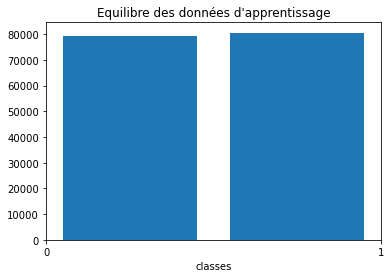

In [2]:
data_test=OL['test_set']
test_review=data_test['review']
test_labels=data_test['polarity']

print(f"taille des données d'apprentissage :{len(train_review)} \ntaille des données test :{len(test_review)}")

# Les données sont-elles équilibrées?

plt.hist(train_labels, bins=2,rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel("classes")
plt.title("Equilibre des données d'apprentissage")
plt.show()

In [7]:
print(train_labels[0:10])
print(train_review[4])

0    0
1    0
2    0
3    0
4    1
5    0
6    1
7    1
8    1
9    0
Name: polarity, dtype: int64
Premier film de la saga Kozure Okami, "Le Sabre de la vengeance" est un très bon film qui mêle drame et action, et qui, en 40 ans, n'a pas pris une ride.


nuage positif


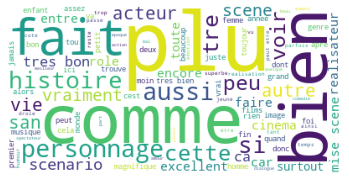

nuage négatif


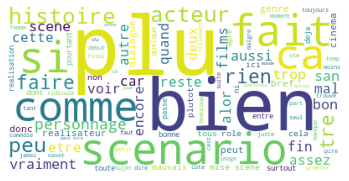

In [2]:
# pré-traitement 

def preprocess_txt(doc):
    punc = string.punctuation  # recupération de la ponctuation
    punc += '\n\r\t'
    doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))  
    doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
    doc = re.sub('[0-9]+', '', doc)
    doc = doc.lower()
    return doc
    
sw = set(stopwords.words('french'))

stopwords={'film','tout'}
for w in sw:
    stopwords.add(preprocess_txt(w))

# optionnel : visualiser le nuage de points
from wordcloud import WordCloud

array_labels_debat=np.array(train_labels)
ind_pos=np.where(array_labels_debat==1)[0]
ind_neg=np.where(array_labels_debat==0)[0]


# Nuage positif
random_train_review=np.random.choice(train_review[ind_pos],5000)
tout=''
for t in random_train_review:
    tout+=t
tout = preprocess_txt(tout)
tout=tout.split()
liste = [word for word in tout if word not in stopwords]
nuage_pos=''
for w in liste:
    nuage_pos += w
    nuage_pos += ' '

    
# Nuage négatif

random_train_review2=np.random.choice(train_review[ind_neg],3000)
tout2=''
for t in random_train_review2:
    tout2+=t
tout2 = preprocess_txt(tout2)
tout2=tout2.split()
liste = [word for word in tout2 if word not in stopwords]
nuage_neg=''
for w in liste:
    nuage_neg += w
    nuage_neg += ' '

print('nuage positif')
wordcloud = WordCloud(background_color = 'white', max_words = 100).generate(nuage_pos)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
      
print('nuage négatif')
wordcloud = WordCloud(background_color = 'white', max_words = 100).generate(nuage_neg)
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 



In [3]:
stemmer = FrenchStemmer()
class StemmedTfidfVectorizer(TfidfVectorizer):
    """
       class customisé pour vectoriser en tf-idf avec stemmer
    """
    def __init__(self, stemmer, preprocessor=None, stop_words=None, max_features=None, min_df=None, max_df=None, ngram_range=(1,1)):
        super(StemmedTfidfVectorizer, self).__init__(
            preprocessor=preprocessor,
            stop_words=stop_words,
            max_features=max_features,
            min_df=min_df, 
            max_df=max_df, 
            ngram_range=ngram_range
        )
        self.stemmer = stemmer

    def fit_transform(self, raw_documents, y=None): 
        """
            fit_transform avec time
        """
        start = time.time()
        res = super().fit_transform(raw_documents, y)
        end = time.time()
        print(f"Fit tranform on {self.__class__.__name__} with data of length {len(raw_documents)} exec in {end - start} secs")
        return res

    def transform(self, raw_documents): 
        """
            transform avec time
        """
        start = time.time()
        res = super().transform(raw_documents)
        end = time.time()
        print(f"tranform on {self.__class__.__name__} with data of length {len(raw_documents)} exec in {end - start} secs")
        return res    
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc:(self.stemmer.stem(w) for w in analyzer(doc))

In [4]:
# Vectorisation des données allociné
vectorizer = StemmedTfidfVectorizer(
    preprocessor=preprocess_txt, 
    stop_words=stopwords, 
    stemmer=stemmer,
    max_features=15000, 
    min_df=2, 
    max_df=0.7, 
    ngram_range=(1,2)
)

X=vectorizer.fit_transform(train_review)

Fit tranform on StemmedTfidfVectorizer with data of length 160000 exec in 631.2475943565369 secs


In [5]:
features=vectorizer.get_feature_names()
features=np.array(features)

In [32]:
text=pickle.load(open("tweet_cible_text.p","rb"))
X_twitter=vectorizer.transform(text)

tranform on StemmedTfidfVectorizer with data of length 2037322 exec in 1272.3165686130524 secs


In [6]:
train_labels=np.array(train_labels)
clf_svm = svm.LinearSVC()
score = cross_val_score(clf_svm, X, train_labels, cv=5).mean()

In [18]:
print(f"Score par cross validation sur les données allo_ciné : {score}")

Score par cross validation sur les données allo_ciné : 0.9242812499999999


In [7]:
clf_svm.fit(X,train_labels)#construction du modèle

LinearSVC()

In [9]:
clf=clf_svm
w=list(clf.coef_)[0] #liste des poids
ind_w=np.argsort(-np.abs(w)) # liste des indices de poids triés par ordre décroissants
print ('plus grand poids :',w[ind_w[0]])
feat_top=features[ind_w[0:100]]
print('les 100 premiers mots clés\n',feat_top)


plus grand poids : -4.651147167972251
les 100 premiers mots clés
 ['plv' 'ennui' 'excellent' 'decept' 'ennuie second' 'magnif' 'decev'
 'mauv' 'superb' 'soporif' 'navet' 'mou' 'epoustoufl' 'tres bon' 'plat'
 'grand chos' 'platitud' 'execr' 'intermin' 'merveil' 'indigest' 'nullit'
 'afflig' 'tres decu' 'dispens' 'jouiss' 'peu passion' 'ridicul'
 'voir absolu' 'ininteress' 'mediocr' 'regal' 'magistral' 'nombril' 'nul'
 'point posit' 'poussif' 'pepit' 'ador' 'ennuie seul' 'bemol' 'calamit'
 'fad' 'sublim' 'seul interet' 'faiblard' 'vaut larg' 'emouv' 'malheur'
 'ennuy' 'inabout' 'interet' 'bijou' 'deux etoil' 'parf' 'parfait'
 'finit lass' 'perfect' 'belle surpris' 'lament' 'amorph' 'oubliabl'
 'risibl' 'confus' 'mollasson' 'jubilatoir' 'abracadabrantesqu'
 'tres moyen' 'desol' 'demander plus' 'genial' 'penibl' 'sans surpris'
 'redecouvr' 'creux' 'previsibl' 'insipid' 'redemand' 'exellent'
 'quel ennui' 'mitig' 'perte temp' 'points posit' 'deconseille moin'
 'scotch' 'hel' 'aucune emot' '

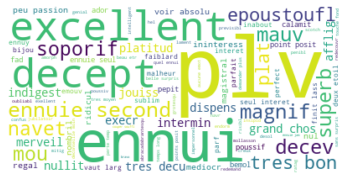

In [15]:
#nuage

#import multidict as multidict
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

dico=dict()
for i in range (100):
    dico[feat_top[i]]=abs(w[ind_w[i]])

def makeImage(text):
    
    wc = WordCloud(background_color="white", max_words=100)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
makeImage(dico)

In [69]:
pred_svm=clf_svm.predict(X_twitter) #calcul des prédictions svm des données twitter

In [16]:
clf_nb = nb.MultinomialNB()
clf_nb.fit(X,train_labels)#construction du modèle
score = cross_val_score(clf_nb, X, train_labels, cv=5).mean()
print(f"Score par cross validation sur les données allo_ciné : {score}")
clf_nb.fit(X,train_labels)


Score par cross validation sur les données allo_ciné : 0.90904375


MultinomialNB()

plus grand poids : -13.15997284470829


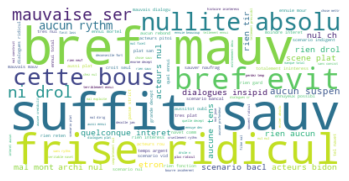

In [20]:
features=vectorizer.get_feature_names()
features=np.array(features)
clf=clf_nb
w=list(clf.coef_)[0] #liste des poids
ind_w=np.argsort(-np.abs(w)) # liste des indices de poids triés par ordre décroissants
print ('plus grand poids :',w[ind_w[0]])
feat_top=features[ind_w[0:100]]
dico2=dict()
for i in range (100):
    dico2[feat_top[i]]=abs(w[ind_w[i]])
makeImage(dico2)

In [66]:
pred_nb=clf_nb.predict(X_twitter)
print(pred_nb.shape)

(2037322,)


In [81]:
from sklearn.utils import shuffle
import random
import pandas as pd

text,pred1,pred2 = shuffle(text,pred_svm,pred_nb)

# Fonction pour évaluer le classifieur
def Evaluation_pred(text,polarite1,polarite2,nombre):
    reponses=[]
    hasard=[]
    for i in range(nombre):
        print(text[i])
        r=input('quelle est la polarité du tweet?')
        h=random.choice([0,1])
        hasard.append(h)
        reponses.append(int(r))
    reponses=np.array(reponses)
    hasard=np.array(hasard)
    if len(np.where(reponses==1)[0])>nombre/2:
        majoritaire = 1
    else :
        majoritaire = 0
    polarite1=polarite1[0:nombre]
    polarite2=polarite2[0:nombre]
    score_classifieur1 = np.mean(reponses==polarite1)
    score_classifieur2 = np.mean(reponses==polarite2)
    score_hasard = np.mean(reponses==hasard)
    score_majoritaire = np.mean (reponses == majoritaire)
    df=pd.DataFrame([[nombre,score_classifieur1,score_classifieur2,score_hasard,score_majoritaire]],columns=['nombre de tests','score SVM','score NB','score_hasard','score_majoritaire'])
    return df


In [77]:
df=Evaluation_pred(text,pred1,pred2,50) # premier test

RT @mormach: Il faut être pragmatique...
#Fillon n'est pas mon candidat, mais c'est le seul qui ait un programme.
Je voterai #Fillon.
quelle est la polarité du tweet?1
RT @francois654: #JLM2017 #FranceInsoumise @JLMelenchon @RaquelGarridoPG @SoChik75 19 points de côte de popularité en 1 semaine ! On… 
quelle est la polarité du tweet?1
RT @visibrain: Le terme lancé par François Fillon pour désigner Emmanuel Macron monte sur les #RS : #EmmanuelHollande plus de 10 0… 
quelle est la polarité du tweet?0
RT @PierreHV1: Ils ont osé lui dire en face. Bravo @Charlineaparis et @GMeurice. #RendsLargent #FillonStrasbourg #Fillon https://t.co/OVdSA…
quelle est la polarité du tweet?0
RT @JLMelenchon: En toute circonstance, priorité à la diplomatie. #JLMFrance2 #Syrie https://t.co/2hQ77Emxh4
quelle est la polarité du tweet?0
RT @jfphilos: Le "référent" de #Macron #MohamedSaou like sur facebook l'imam salafiste responsable du #Bataclan. Hallucinant! https://t.co/…
quelle est la polarité du tweet?0
RT 

In [78]:
df.head()

,nombre de tests,score SVM,score NB,score_hasard,score_majoritaire
0,50,0.62,0.56,0.36,0.64


In [82]:
df2=Evaluation_pred(text,pred1,pred2,50) #deuxième test

RT @maelle128: "Il faut être raisonnables car nous sommes dans un enchainement guerrier " @JLMelenchon #JLM2017 
#Presidentielle2017 #JLMFr…
quelle est la polarité du tweet?1
RT @fo_sag: La claque de @PhilippePoutou à Marine #LePen. Moment d'anthologie.. #LeGrandDebat ... https://t.co/wiN3KlbBlx
quelle est la polarité du tweet?0
RT @Delphine_D: Bourdin s'étrangle : "Baisser les charges sans demander de contrepartie ???".
#Fillon lui rappelle gentiment qu'on n'est pa…
quelle est la polarité du tweet?1
RT @leJRepublicain: Et après les macronistes nous disent sur les marchés "Non mais #Macron n'a rien à voir avec #Hollande" ? Si ! Et de… 
quelle est la polarité du tweet?0
RT @oni_apt_: Quand les racailles du Front National tabasse tranquillement @Marion_M_Le_Pen #FN #Fhaine https://t.co/SBBKsLHohQ
quelle est la polarité du tweet?0
@EmmanuelMacron un programme plein de... vent ? https://t.co/YftumkeBzo #macron2017 #Presidentielle2017
quelle est la polarité du tweet?1
?? #AuNomDuPeuple ?? #

In [83]:
df2.head()

,nombre de tests,score SVM,score NB,score_hasard,score_majoritaire
0,50,0.46,0.46,0.42,0.56


In [93]:
a =(df['nombre de tests'].unique()+df2['nombre de tests'].unique())[0]
b=(df['score SVM'].unique()+df2['score SVM'].unique())[0]/2
c=(df['score NB'].unique()+df2['score NB'].unique())[0]/2
d=(df['score_hasard'].unique()+df2['score_hasard'].unique())[0]/2
e=(df['score_majoritaire'].unique()+df2['score_majoritaire'].unique())[0]/2

In [94]:
df_t=pd.DataFrame([[a,b,c,d,e]],columns=['nombre de tests','score SVM','score NB','score_hasard','score_majoritaire'])
df_t.head() 

,nombre de tests,score SVM,score NB,score_hasard,score_majoritaire
0,100,0.54,0.51,0.39,0.6
